In [1]:
# importing packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from pickle import dump, load
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('/Users/SnehPandya/Desktop/nn/train_drw_full.csv')
df2 = pd.read_csv('/Users/SnehPandya/Desktop/nn/test_drw_zmipred.csv')
# df2 = df2.drop(columns = ['mu'])

In [3]:
df.head()

,ID,Mass_ground_truth,RA,DEC,tau_lim_lo,tau_lim_hi,sig_lim_lo,sig_lim_hi,mu,u_band,...,z_band,z,M_i,ug,gr,ri,iz,zu,tau,sigma
0,49159,9.284316,0.027228,0.515349,2.49379,4.35451,-0.701226,-0.491335,20.1577,20.216891,...,20.026435,1.8227,-25.100,0.066609,-0.030761,0.218283,-0.063674,-0.190457,2.64638,-0.555389
1,24646,8.287811,0.049842,0.040372,2.01338,3.51705,-0.787068,-0.614831,18.0157,18.039429,...,17.690816,0.4790,-24.046,0.238531,-0.050367,0.082918,0.077531,-0.348612,2.22711,-0.660666
2,113067,8.591425,0.051076,-0.539049,2.39531,4.27549,-0.664451,-0.429594,20.5704,20.523949,...,20.200915,1.4365,-24.529,0.052780,0.229390,0.109610,-0.068746,-0.323034,2.54143,-0.495080
3,35034,9.483711,0.057505,-0.913004,2.98242,4.60146,-1.124520,-0.857041,20.3372,20.253569,...,19.407466,1.8361,-25.648,0.186000,0.143224,0.447431,0.069448,-0.846103,3.25353,-0.974542
4,18787,8.645721,0.061778,-1.175193,2.86962,4.59463,-0.890711,-0.675474,19.4620,19.554245,...,19.300898,1.8902,-26.149,0.022714,0.034735,0.197388,-0.001490,-0.253347,3.08560,-0.747354


In [4]:
df2.head()
df.iloc[1,14:]

z         0.479000
M_i     -24.046000
ug        0.238531
gr       -0.050367
ri        0.082918
iz        0.077531
zu       -0.348612
tau       2.227110
sigma    -0.660666
Name: 1, dtype: float64

In [5]:
class BHDataset(Dataset):
    def __init__(self, path, train=True):
        self.path = path
        self.train = train
        self.sc = StandardScaler()

        if self.train:
            self.data = pd.read_csv(self.path + 'train_drw_full.csv')
            self.features = self.sc.fit_transform(np.asarray(self.data.iloc[:,14:]))
            dump(self.sc, open('train_scaler_reject_zmi.pkl','wb'))
        
        else:
            self.data = pd.read_csv(self.path + 'test_drw_full.csv')
#             self.data = self.data.drop(columns = ['Unnamed: 0'])
            self.sc = load(open('train_scaler_reject_zmi.pkl','rb'))
            self.features = self.sc.transform(np.asarray(self.data.iloc[:,14:]))
            
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):

        ID = torch.from_numpy(np.asarray(self.data.iloc[index,0]))
        mass = torch.from_numpy(np.asarray(self.data.iloc[index,1]))
        features = torch.from_numpy(self.features[index].reshape(1,-1))
        return (ID, features, mass)

        
train_ds = BHDataset('/Users/SnehPandya/Desktop/nn/')
test_ds = BHDataset('/Users/SnehPandya/Desktop/nn/', train=False) 
train_ds.__getitem__(0)

(tensor(49159),
 tensor([[ 0.3384,  0.0064, -0.6302, -1.0979,  0.3999, -1.1896,  0.9270, -0.0395,
           0.0019]], dtype=torch.float64),
 tensor(9.2843, dtype=torch.float64))

In [6]:
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

net = Net()
net.load_state_dict(torch.load('/Users/SnehPandya/Desktop/AGNet_100epoch_drw_9_357.mdl'))

<All keys matched successfully>

In [8]:
# loss function and optimizer
optimizer = optim.AdamW(net.parameters(), lr=0.001)
loss_function = F.smooth_l1_loss

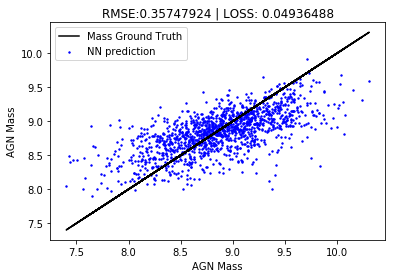

In [9]:
# testing loop
def test(net):

    with torch.no_grad():
        outputs_ID, outputs_pred, outputs_mass = ([] for i in range(3))
        
        for data in test_dl:
            ID, X, mass = data  # X is the batch of features, y is the batch of targets.
            outputs_ID.append(ID)
            outputs_mass.append(mass.float())
            output = net(X.float()) # pass in the reshaped batch (recall they are 28x28 atm)
            outputs_pred.append(output.float())
            loss = loss_function(output.squeeze(), mass.float().squeeze())# calc and grab the loss value

        ground_truth = torch.cat(outputs_mass).data # .stack for using dataset (.cat for dataloader)
        predictions = torch.cat(outputs_pred).data.flatten()
        ID = torch.cat(outputs_ID).data
        rmse = np.sqrt(metrics.mean_squared_error(ground_truth, predictions))
        plt.plot(ground_truth, ground_truth,color='black', label = 'Mass Ground Truth')
        plt.scatter(ground_truth,predictions,s=2, color='blue', label = 'NN prediction')
        plt.title('RMSE:' + str(rmse) + ' | LOSS: ' + str(loss.data.numpy()))
        plt.xlabel('AGN Mass')
        plt.ylabel('AGN Mass')
        plt.legend()
        plt.show()
        
        df = pd.DataFrame({'ID':ID.numpy(), 'ground truth':ground_truth.numpy(), 'network predictions':predictions.numpy() })
        return df
df = test(net)

In [10]:
# df.to_csv('/Users/SnehPandya/Desktop/nn/mass_drw_zmipred_results.csv')
df.to_csv('/Users/SnehPandya/Desktop/nn/mass_drw_results_FINAL.csv')

In [21]:
r2_score(df['ground truth'], df['network predictions'])

0.27251604224996673